<a href="https://colab.research.google.com/github/Shruthi-Arun/Macroeconomic-Indicators-for-Stock-Dynamics/blob/main/Notebooks/VECM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera, skew, kurtosis
import matplotlib.pyplot as plt

In [ ]:
csv_path = "macro_data_cleaned.csv"

In [ ]:
df = pd.read_csv(csv_path, parse_dates=['Date'], index_col='Date')

In [ ]:
df.head()

,Inflation,Unemployment,Interest_Rate,GDP,Industrial_Output,Money_Supply,Consumer_Confidence,Treasury_Yield,SP500_Returns
Date,,,,,,,,,
1959-01-31,29.01,6.0,2.48,3352.129,21.9616,286.6,90.8,4.02,0.434707
1959-02-28,29.00,5.9,2.43,3352.129,22.3917,287.7,90.8,3.96,-0.072139
1959-03-31,28.97,5.6,2.80,3352.129,22.7142,289.2,90.8,3.99,0.054140
1959-04-30,28.98,5.2,2.96,3427.667,23.1981,290.1,90.8,4.12,3.878069
1959-05-31,29.04,5.1,2.90,3427.667,23.5476,292.2,95.3,4.31,1.892690


In [ ]:
df = df.sort_index()
df = df.asfreq('M')

/tmp/ipython-input-1345135640.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.asfreq('M')


In [ ]:
print("Date range:", df.index.min().strftime("%Y-%m-%d"), "to", df.index.max().strftime("%Y-%m-%d"))
print("Shape:", df.shape)
print(df.head())

Date range: 1959-01-31 to 2025-09-30
Shape: (801, 9)
            Inflation  Unemployment  Interest_Rate       GDP  \
Date                                                           
1959-01-31      29.01           6.0           2.48  3352.129   
1959-02-28      29.00           5.9           2.43  3352.129   
1959-03-31      28.97           5.6           2.80  3352.129   
1959-04-30      28.98           5.2           2.96  3427.667   
1959-05-31      29.04           5.1           2.90  3427.667   

            Industrial_Output  Money_Supply  Consumer_Confidence  \
Date                                                               
1959-01-31            21.9616         286.6                 90.8   
1959-02-28            22.3917         287.7                 90.8   
1959-03-31            22.7142         289.2                 90.8   
1959-04-30            23.1981         290.1                 90.8   
1959-05-31            23.5476         292.2                 95.3   

            Treasury_

In [ ]:
print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
Inflation              0
Unemployment           0
Interest_Rate          0
GDP                    0
Industrial_Output      0
Money_Supply           0
Consumer_Confidence    0
Treasury_Yield         0
SP500_Returns          0
dtype: int64


In [ ]:
# Function to check if a series is I(1) (non-stationary in level)
def is_nonstationary(series, alpha=0.05):
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    return p_value > alpha  # True if non-stationary

log_candidates = []

In [ ]:
for col in df.columns:
    if (df[col] > 0).all():
        if is_nonstationary(df[col]):
            log_candidates.append(col)

print("Columns suggested for log-transform:", log_candidates)

Columns suggested for log-transform: ['Inflation', 'GDP', 'Industrial_Output', 'Money_Supply', 'Treasury_Yield']


In [ ]:
def adf_summary(series, col_name):
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    stationary = p_value < 0.05
    print(f"{col_name:20s} | p-value: {p_value:.4f} | Stationary: {stationary}")
    return stationary

In [ ]:
print("=== Log-transformed variables ===")
for col in log_candidates:
    df[f'log_{col}'] = np.log(df[col])
    adf_summary(df[f'log_{col}'], f"log_{col}")

=== Log-transformed variables ===
log_Inflation        | p-value: 0.5587 | Stationary: False
log_GDP              | p-value: 0.1836 | Stationary: False
log_Industrial_Output | p-value: 0.1918 | Stationary: False
log_Money_Supply     | p-value: 0.5225 | Stationary: False
log_Treasury_Yield   | p-value: 0.3134 | Stationary: False


In [ ]:
print("\n=== Level variables ===")
level_vars = [c for c in df.columns if c not in log_candidates and c not in [f"log_{v}" for v in log_candidates]]
for col in level_vars:
    adf_summary(df[col], col)


=== Level variables ===
Unemployment         | p-value: 0.0101 | Stationary: True
Interest_Rate        | p-value: 0.0418 | Stationary: True
Consumer_Confidence  | p-value: 0.0360 | Stationary: True
SP500_Returns        | p-value: 0.0000 | Stationary: True


In [ ]:
johansen_data = df[['log_Inflation', 'log_GDP', 'log_Industrial_Output', 'log_Money_Supply', 'log_Treasury_Yield']]

# Johansen Test
# det_order=0 means no deterministic trend, can change to -1 for automatic selection
# k_ar_diff = lag order for differences (we can start with 1, will tune later)
johansen_test = coint_johansen(johansen_data, det_order=0, k_ar_diff=1)

In [ ]:
# Summary of test statistics
print("Eigenvalues:\n", johansen_test.eig)
print("\nTrace Statistic:", johansen_test.lr1)  # Trace statistic
print("Critical Values (90%, 95%, 99%):\n", johansen_test.cvt)

Eigenvalues:
 [0.12328181 0.0501679  0.01320278 0.00600993 0.00085116]

Trace Statistic: [162.36480223  57.24063674  16.11606932   5.49679021   0.68036662]
Critical Values (90%, 95%, 99%):
 [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [ ]:
# Use only I(1) variables for lag selection
vecm_vars = df[['log_Inflation', 'log_GDP', 'log_Industrial_Output', 'log_Money_Supply', 'log_Treasury_Yield']]


In [ ]:
# Fitting VAR to determine optimal lag order
model_var = VAR(vecm_vars)
lag_order_results = model_var.select_order(maxlags=12)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.55      -17.52   2.391e-08      -17.54
1       -48.13      -47.95   1.257e-21      -48.06
2       -49.28      -48.95   3.973e-22      -49.15
3       -49.57     -49.10*   2.965e-22      -49.39
4       -49.67      -49.05   2.681e-22     -49.43*
5       -49.69      -48.92   2.639e-22      -49.39
6       -49.71      -48.79   2.575e-22      -49.36
7       -49.75      -48.68   2.480e-22      -49.34
8       -49.73      -48.51   2.540e-22      -49.26
9       -49.74      -48.37   2.514e-22      -49.21
10      -49.76      -48.25   2.453e-22      -49.18
11      -49.78      -48.12   2.415e-22      -49.14
12     -49.79*      -47.98  2.391e-22*      -49.09
--------------------------------------------------


AIC minimum: lag = 12

BIC minimum: lag = 3

FPE minimum: lag = 12

HQIC minimum: lag = 4

Practical Choice:

AIC/FPE often prefer longer lags (can overfit)

BIC/HQIC prefer shorter lags (more parsimonious)

For now:

Starting with a moderate lag like 3 or 4 (BIC/HQIC)

Can experiment later to see if results are stable

For now, using lag = 3 for VECM.

In [ ]:
vecm_data = df[['log_Inflation', 'log_GDP', 'log_Industrial_Output', 'log_Money_Supply', 'log_Treasury_Yield',
                'SP500_Returns', 'Unemployment', 'Interest_Rate', 'Consumer_Confidence']]

In [ ]:
# Fit VECM
vecm = VECM(endog=vecm_data, k_ar_diff=2, coint_rank=2, deterministic="ci")  # ci = constant in cointegration
vecm_res = vecm.fit()

In [ ]:
print(vecm_res.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation log_Inflation
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
L1.log_Inflation             0.4321      0.036     12.032      0.000       0.362       0.502
L1.log_GDP                  -0.0089      0.014     -0.627      0.531      -0.037       0.019
L1.log_Industrial_Output    -0.0174      0.011     -1.553      0.120      -0.039       0.005
L1.log_Money_Supply         -0.0514      0.027     -1.898      0.058      -0.105       0.002
L1.log_Treasury_Yield        0.0057      0.002      3.584      0.000       0.003       0.009
L1.SP500_Returns          4.125e-06   2.95e-05      0.140      0.889   -5.36e-05    6.19e-05
L1.Unemployment           3.918e-05      0.000      0.142      0.887      -0.001       0.001
L1.Interest_Rate             0.0005      0.000      2.716      0.007  

In [ ]:
resid = vecm_res.resid
# Autocorrelation: Ljung-Box
lb_tests = []

for i in range(resid.shape[1]):
    lb = acorr_ljungbox(resid[:, i], lags=[10], return_df=True)
    lb['variable'] = vecm_data.columns[i]  # optional: add variable name
    lb_tests.append(lb)

lb_test_df = pd.concat(lb_tests)
print(lb_test_df)

# Normality: Jarque-Bera

jb_test_list = []
for i in range(resid.shape[1]):
    series = resid[:, i]
    jb_stat, jb_pvalue = jarque_bera(series)
    s = skew(series)
    k = kurtosis(series)
    jb_test_list.append([vecm_data.columns[i], jb_stat, jb_pvalue, s, k])

jb_test_df = pd.DataFrame(jb_test_list, columns=['variable', 'JB_stat', 'JB_pvalue', 'skew', 'kurtosis'])
print(jb_test_df)

# Stability
var_model = VAR(vecm_data)
var_res = var_model.fit(maxlags=vecm.k_ar_diff)

k = var_res.neqs  # number of endogenous variables
p = var_res.k_ar  # number of lags

comp_matrix = np.zeros((k * p, k * p))
comp_matrix[:k, :] = np.hstack(var_res.coefs)  # top row: VAR coefficients
if p > 1:
    comp_matrix[k:, :-k] = np.eye(k * (p - 1))  # identity blocks for lagged variables

eigvals = np.linalg.eigvals(comp_matrix)

is_stable = np.all(np.abs(eigvals) < 1)

print("Eigenvalues of the VAR system:", eigvals)
print("Is the system stable?", is_stable)

      lb_stat     lb_pvalue               variable
10  34.127654  1.757234e-04          log_Inflation
10  69.594560  5.309195e-11                log_GDP
10  17.118649  7.177946e-02  log_Industrial_Output
10  41.435318  9.447521e-06       log_Money_Supply
10   7.815712  6.468324e-01     log_Treasury_Yield
10   7.744452  6.537825e-01          SP500_Returns
10  16.958003  7.529844e-02           Unemployment
10  57.051197  1.303742e-08          Interest_Rate
10  31.009742  5.845559e-04    Consumer_Confidence
                variable       JB_stat      JB_pvalue       skew    kurtosis
0          log_Inflation  5.420908e+02  1.934124e-118  -0.033821    4.037190
1                log_GDP  6.852852e+03   0.000000e+00  -0.782919   14.270563
2  log_Industrial_Output  2.785707e+04   0.000000e+00  -2.017296   28.662324
3       log_Money_Supply  1.369762e+04   0.000000e+00   1.690711   20.013108
4     log_Treasury_Yield  3.561090e+03   0.000000e+00  -0.858796   10.205407
5          SP500_Returns  8.

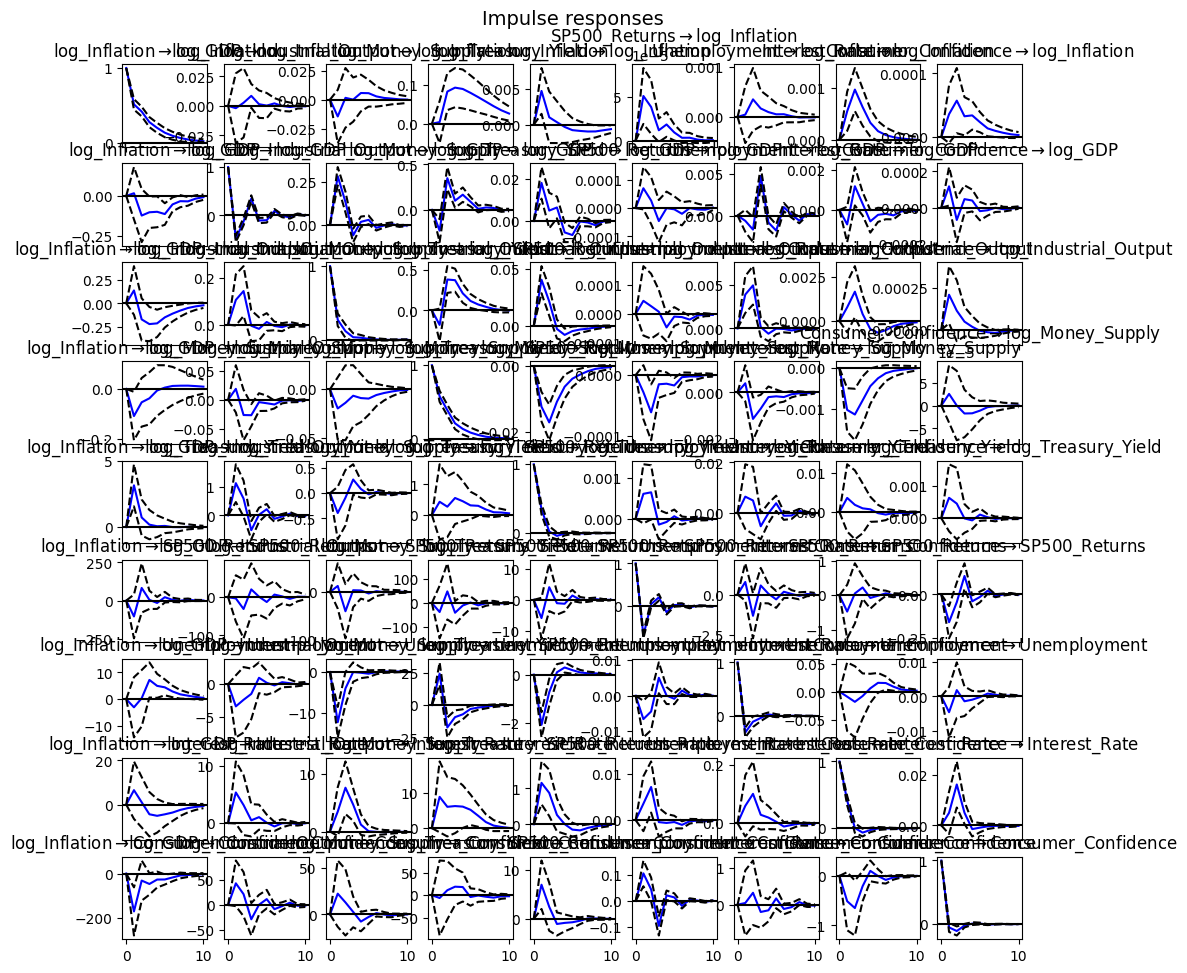

FEVD for log_Inflation
     log_Inflation   log_GDP  log_Industrial_Output  log_Money_Supply  log_Treasury_Yield  SP500_Returns  Unemployment  Interest_Rate  Consumer_Confidence
0         1.000000  0.000000               0.000000          0.000000            0.000000       0.000000      0.000000       0.000000             0.000000
1         0.970671  0.000243               0.000860          0.000521            0.010201       0.007449      0.000052       0.007772             0.002231
2         0.936765  0.000591               0.000886          0.006385            0.010193       0.009787      0.001516       0.027154             0.006722
3         0.921897  0.000575               0.001050          0.014099            0.009917       0.009384      0.001775       0.033548             0.007756
4         0.912334  0.000593               0.001024          0.021229            0.009587       0.009817      0.001799       0.034586             0.009031
5         0.905941  0.000620               0.00

In [ ]:
var_res = vecm.fit()

vecm_diff = vecm_data.diff().dropna()  # first differences
var_model = VAR(vecm_diff)
var_res = var_model.fit(maxlags=2)

# Impulse Response Function (IRF)
irf = var_res.irf(10)  # horizon=10 months
irf.plot(orth=False)   # orthogonalized=False
plt.show()

# To get numerical values
irf_values = irf.irfs  # shape: (horizon+1, n_variables, n_variables)

# Forecast Error Variance Decomposition (FEVD)
fevd = var_res.fevd(10)  # horizon=10
fevd_summary = fevd.summary()  # textual summary
print(fevd_summary)

# FEVD values
fevd_values = fevd.decomp